In [26]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"


In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

In [3]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

print(files.keys())
bkg = read_h5_file(database_path, files["SM"])
# SM processes

neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

leptoquark = read_h5_file(database_path, files["leptoquark"])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino

dict_keys(['SM', 'neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs'])


In [4]:
model_hyper_parameters = load_toml_config("Transformer")
print(model_hyper_parameters)
feature_size = model_hyper_parameters["feature_size"]
embed_size = model_hyper_parameters["embed_size"]
num_heads = model_hyper_parameters["num_heads"]
num_layers = model_hyper_parameters["num_layers"]
hidden_dim = model_hyper_parameters["hidden_dim"]
output_dim = model_hyper_parameters["output_dim"]

model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)

{'feature_size': 3, 'embed_size': 16, 'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'output_dim': 4}


/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
from analysis import inference

In [6]:
from data import EventDataset

In [43]:
infer_test_num = 1000000
bkg_infer_test = bkg[:infer_test_num]
infer_dataset = EventDataset(bkg_infer_test)
infer_dataloader = DataLoader(infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_boson_infer_test = neutral_boson[:infer_test_num]
neutral_boson_infer_dataset = EventDataset(neutral_boson_infer_test)
neutral_boson_infer_dataloader = DataLoader(neutral_boson_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

leptoquark_infer_test = leptoquark[:infer_test_num]
leptoquark_infer_dataset = EventDataset(leptoquark_infer_test)
leptoquark_infer_dataloader = DataLoader(leptoquark_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_Higgs_infer_test = neutral_Higgs[:infer_test_num]
neutral_Higgs_infer_dataset = EventDataset(neutral_Higgs_infer_test)
neutral_Higgs_infer_dataloader = DataLoader(neutral_Higgs_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

charged_Higgs_infer_test = charged_Higgs[:infer_test_num]
charged_Higgs_infer_dataset = EventDataset(charged_Higgs_infer_test)
charged_Higgs_infer_dataloader = DataLoader(charged_Higgs_infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

In [44]:
model.load_state_dict(torch.load(os.path.join("..", "model","emb_dim{}_type_scale{}.pt".format(output_dim, particle_type_scale))))
model.to(device)
bkg_embed_points = inference(model, infer_dataloader, embed_dim=output_dim)
print(bkg_embed_points.shape)

100%|██████████| 3907/3907 [00:08<00:00, 474.55it/s]

(1000000, 4)


In [45]:
neutral_boson_embed_points = inference(model, neutral_boson_infer_dataloader, embed_dim=output_dim)
leptoquark_embed_points = inference(model, leptoquark_infer_dataloader, embed_dim=output_dim)
neutral_Higgs_embed_points = inference(model, neutral_Higgs_infer_dataloader, embed_dim=output_dim)
charged_Higgs_embed_points = inference(model, charged_Higgs_infer_dataloader, embed_dim=output_dim)


100%|██████████| 2970/2970 [00:06<00:00, 469.22it/s]


In [47]:
class ClassifyDataset(Dataset):
    def __init__(self, bkg_event, sig_event, lambda_=0.2, n_events=100000):
        exp_n_sig = int(n_events * lambda_)
        exp_n_bkg = n_events - exp_n_sig
        exp_bkg_event = bkg_event[:exp_n_bkg]
        exp_sig_event = sig_event[:exp_n_sig]
        exp_event = np.concatenate([exp_bkg_event, exp_sig_event], axis=0)
        bkg_event = bkg_event[exp_n_bkg:exp_n_bkg + n_events]
        # Normalize the data
        bkg_events = (bkg_event - bkg_event.mean()) / bkg_event.std()
        exp_events = (exp_event - exp_event.mean()) / exp_event.std()

        bkg_events = torch.from_numpy(bkg_events).float()
        exp_events = torch.from_numpy(exp_events).float()
        self.events = torch.cat([bkg_events, exp_events], dim=0)
        self.labels = torch.cat([torch.zeros(len(bkg_events)), torch.ones(len(exp_events))])
    
    def __len__(self):
        return len(self.events)
    
    def __getitem__(self, idx):
        return self.events[idx], self.labels[idx]

In [48]:
val_ratio = 0.2
train_num_bkg = int(len(bkg_embed_points) * (1 - val_ratio))
train_num_sig = int(len(charged_Higgs_embed_points) * (1 - val_ratio))


train_dataset = ClassifyDataset(bkg_embed_points[:train_num_bkg], charged_Higgs_embed_points[:train_num_sig])
val_dataset = ClassifyDataset(bkg_embed_points[train_num_sig:], charged_Higgs_embed_points[train_num_sig:])

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)

In [50]:
num_batches_to_print = 3

for i, (features, labels) in enumerate(train_dataloader):
    print(f"Batch {i + 1}")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Features dtype: {features.dtype}")
    print(f"Labels dtype: {labels.dtype}")
    print("Sample features:", features[0]) 
    print("Sample labels:", labels[0])

    if i + 1 == num_batches_to_print:
        break

Batch 1
Features shape: torch.Size([16, 4])
Labels shape: torch.Size([16])
Features dtype: torch.float32
Labels dtype: torch.float32
Sample features: tensor([ 0.6793,  0.0417, -0.3466,  0.4540])
Sample labels: tensor(1.)
Batch 2
Features shape: torch.Size([16, 4])
Labels shape: torch.Size([16])
Features dtype: torch.float32
Labels dtype: torch.float32
Sample features: tensor([ 0.8296, -1.0632, -0.8525,  0.8846])
Sample labels: tensor(0.)
Batch 3
Features shape: torch.Size([16, 4])
Labels shape: torch.Size([16])
Features dtype: torch.float32
Labels dtype: torch.float32
Sample features: tensor([0.0851, 0.6766, 0.3093, 0.1274])
Sample labels: tensor(1.)


# Model

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLP, self).__init__()
        def make_layer(in_size, out_size):
            layer = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.LeakyReLU(),
                # nn.Dropout(0.1)
            )
            nn.init.kaiming_normal_(layer[0].weight, nonlinearity='leaky_relu')
            return layer
        self.layers = nn.Sequential(
            make_layer(input_size, hidden_sizes[0]),
            *[make_layer(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)],
            nn.Linear(hidden_sizes[-1], 1),
            nn.Sigmoid()
        )
    

    def forward(self, x):
        return self.layers(x).reshape(-1)
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

In [18]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(4, 8)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(8, 16)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(16, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        x = x.squeeze()
        return x

naive_model = Deep()

# Train

In [19]:
class BinaryACCUpdater(nn.Module):
    def __init__(self, threshold=0.5):
        super(BinaryACCUpdater, self).__init__()
        self.total_acc = 0
        self.count = 0
        self.threshold = threshold
    def forward(self, output, label):
        acc = (output > self.threshold).float() == label
        mean_acc = acc.float().mean()
        self.update(mean_acc)
        return mean_acc
    def update(self, metric):
        self.total_acc += metric
        self.count += 1
    def compute(self):
        return self.total_acc / self.count
    def reset(self):
        self.total_acc = 0
        self.count = 0

In [20]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
from torcheval.metrics import BinaryAccuracy
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [21]:
from classify import train_model

In [ ]:
opt_train_model  = torch.compile(train_model)

In [22]:
opt_train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=10
    )


================================================================================2024-05-09 20:12:27
Epoch 1 / 10

100%|██████████| 157/157 [00:00<00:00, 416.44it/s, val_Accuracy=0.944, val_loss=0.134] 
<<<<<< reach best val_Accuracy : 0.944491446018219 >>>>>>

================================================================================2024-05-09 20:12:41
Epoch 2 / 10

100%|██████████| 157/157 [00:00<00:00, 623.77it/s, val_Accuracy=0.948, val_loss=0.124] 
<<<<<< reach best val_Accuracy : 0.9478254318237305 >>>>>>

================================================================================2024-05-09 20:12:55
Epoch 3 / 10

100%|██████████| 157/157 [00:00<00:00, 635.38it/s, val_Accuracy=0.952, val_loss=0.116] 
<<<<<< reach best val_Accuracy : 0.951681911945343 >>>>>>

================================================================================2024-05-09 20:13:09
Epoch 4 / 10

100%|██████████| 157/157 [00:00<00:00, 665.67it/s, val_Accuracy=0.949, val_loss=0.126] 

============

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.166147,0.930531,0.133602,0.944491,1
1,0.120488,0.950925,0.124109,0.947825,2
2,0.113450,0.954131,0.115898,0.951682,3
3,0.108230,0.956200,0.125504,0.949269,4
4,0.105816,0.956844,0.115197,0.952005,5
5,0.104458,0.957644,0.111695,0.953672,6
6,0.103271,0.958312,0.110193,0.953448,7
7,0.102714,0.958537,0.111535,0.952403,8
8,0.102022,0.958737,0.109617,0.953697,9
9,0.101631,0.959294,0.110642,0.953523,10


# ROC

In [27]:
@torch.no_grad()
def predict(model, dataloader):
    model.eval()
    batch_size = dataloader.batch_size
    targets = np.zeros(len(dataloader.dataset))
    predictions = np.zeros(len(dataloader.dataset))
    for i, (features, labels) in enumerate(tqdm(dataloader)):
        features = features.to(device)
        outputs = model(features)
        targets[i * batch_size: (i + 1) * batch_size] = labels.numpy()
        predictions[i * batch_size: (i + 1) * batch_size] = outputs.cpu().numpy()
    return targets, predictions

In [28]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 157/157 [00:00<00:00, 1120.64it/s]


In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [40]:
def calculate_auc(targets, predictions):
    fpr, tpr, thersholds = roc_curve(targets, predictions)
    auc_roc = auc(fpr, tpr)
    return fpr, tpr, auc_roc

In [37]:
def plot_roc_curve(fpr, tpr, auc_roc, title):
    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(auc_roc), lw=2)    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPT')
    plt.ylabel('TPR') 
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


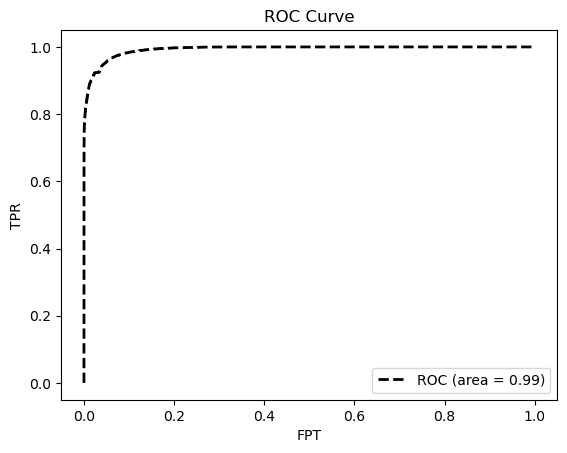

In [41]:
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
plot_roc_curve(fpr, tpr, auc_roc, "ROC Curve")